In [11]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import bds

In [3]:
dados = pd.read_csv('./data/ibit-usd.csv')[["Date", "Adj Close"]]
dados['Returns'] = np.log(dados['Adj Close']/dados['Adj Close'].shift(1))
dados = dados[['Date', 'Adj Close', 'Returns']].dropna()
dados

,Date,Adj Close,Returns
1,2024-01-12,24.969999,-0.064363
2,2024-01-16,24.719999,-0.010062
3,2024-01-17,24.410000,-0.012620
4,2024-01-18,23.340000,-0.044824
5,2024-01-19,23.799999,0.019517
...,...,...,...
215,2024-11-18,52.130001,0.000000
216,2024-11-19,52.700001,0.010875
217,2024-11-20,53.720001,0.019170
218,2024-11-21,55.900002,0.039779


In [6]:
# Coluna de interesse
returns = dados['Returns']

# Teste de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(returns)
print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# Teste de Anderson-Darling
anderson_result = stats.anderson(returns, dist='norm')
print(f"Anderson-Darling Test: Statistic={anderson_result.statistic:.4f}, Critical Values={anderson_result.critical_values}")

# Teste de Kolmogorov-Smirnov (com normalização)
ks_stat, ks_p = stats.kstest(returns, 'norm', args=(returns.mean(), returns.std()))
print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")


Shapiro-Wilk Test: Statistic=0.9774, p-value=0.0014
Anderson-Darling Test: Statistic=1.0487, Critical Values=[0.566 0.645 0.773 0.902 1.073]
Kolmogorov-Smirnov Test: Statistic=0.0671, p-value=0.2648


Shapiro-Wilk Test Statistic: 0.9773810417441565
p-value: 0.00137590787068795


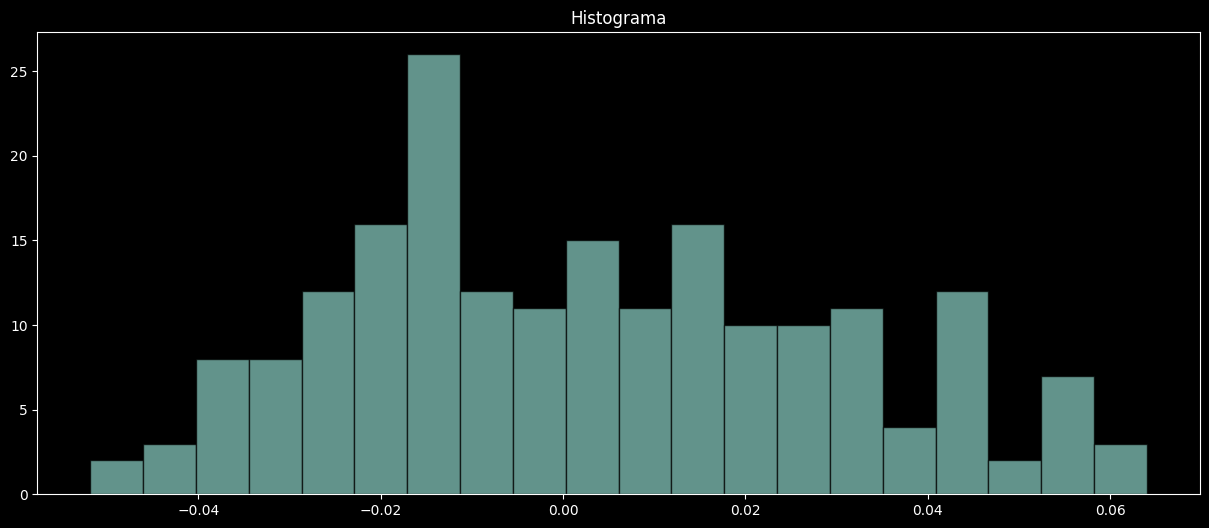

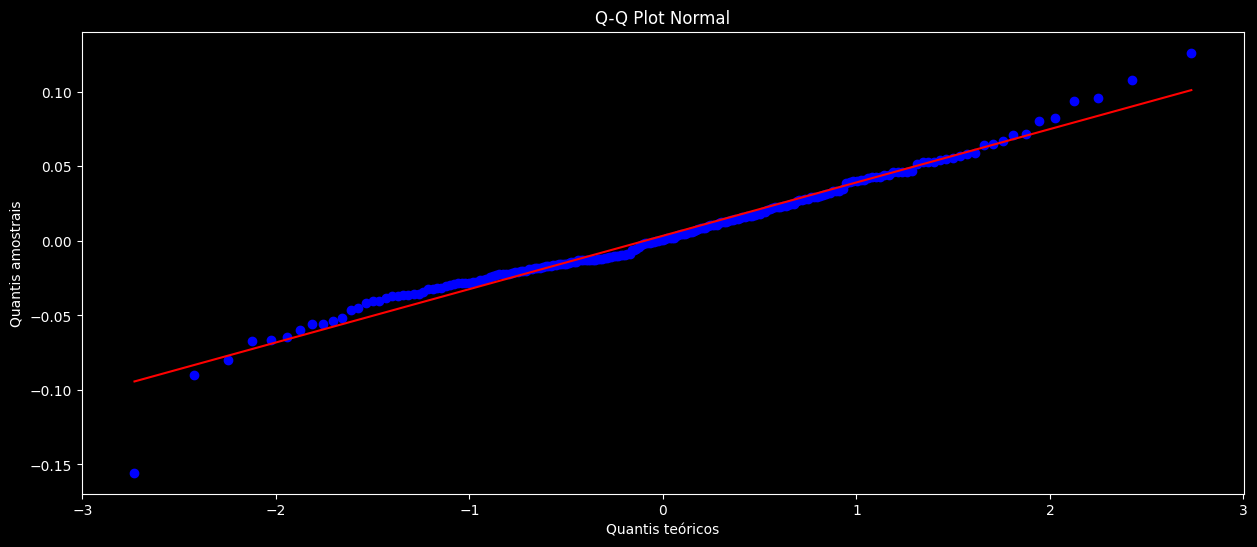

Parâmetros ajustados da normal: μ=0.00, σ=0.04
Estatística do teste KS para normal: 0.0674, p-valor: 0.2602
Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição normal.


Parâmetros ajustados da distribuição t: ν=7.30, μ=0.00, σ=0.03
Estatística do teste KS: 0.0746, p-valor: 0.1660
Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição t.


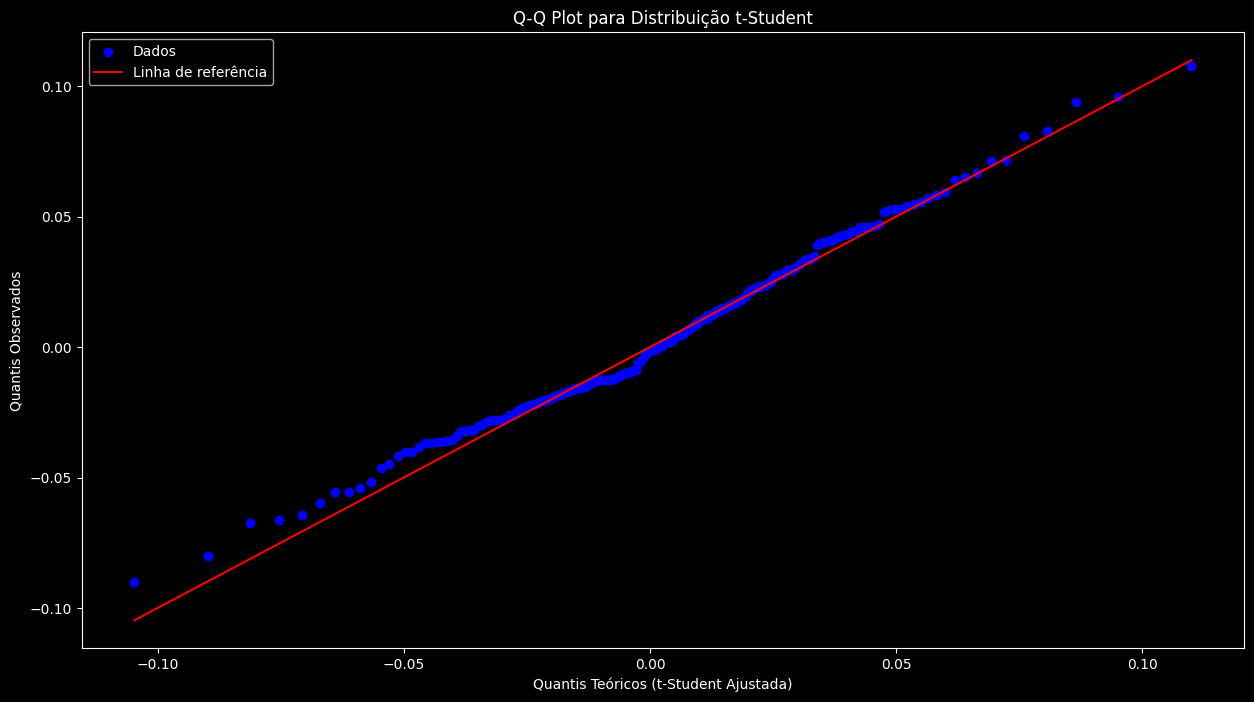

In [10]:
data = dados['Returns']

n_strip = int(len(dados)*0.05)
data_strip = np.sort(dados['Returns'])[n_strip:-n_strip]

# Teste de Shapiro-Wilk
shapiro_test = stats.shapiro(data)
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("p-value:", shapiro_test.pvalue)

# Histograma e Q-Q Plot Normal
plt.figure(figsize=(15, 6))
plt.hist(data_strip, bins=20, edgecolor='k', alpha=0.7)
plt.title('Histograma')
plt.show()


plt.figure(figsize=(15, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot Normal')

plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = 'black'

plt.xlabel('Quantis teóricos')
plt.ylabel('Quantis amostrais')

plt.show()

# Teste Normal
norm_params = stats.norm.fit(data)
print(f"Parâmetros ajustados da normal: μ={norm_params[0]:.2f}, σ={norm_params[1]:.2f}")

# Teste KS para a normal
ks_stat_norm, p_value_norm = stats.kstest(data, "norm", args=norm_params)
print(f"Estatística do teste KS para normal: {ks_stat_norm:.4f}, p-valor: {p_value_norm:.4f}")

if p_value_norm > 0.05:
    print("Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição normal.\n\n")
else:
    print("Os dados não seguem uma distribuição normal.\n\n")


# Teste t
t_params = stats.t.fit(data)
df, loc, scale = t_params

t_params = stats.t.fit(data)
print(f"Parâmetros ajustados da distribuição t: ν={t_params[0]:.2f}, μ={t_params[1]:.2f}, σ={t_params[2]:.2f}")

# Teste KS comparando os dados à distribuição t ajustada
ks_stat, p_value = stats.kstest(data, "t", args=t_params)
print(f"Estatística do teste KS: {ks_stat:.4f}, p-valor: {p_value:.4f}")

if p_value > 0.05:
    print("Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição t.")
else:
    print("Os dados não seguem uma distribuição t.")

# Criar o Q-Q Plot t-student

# Ajustar os parâmetros da distribuição t
t_params = stats.t.fit(data)
df, loc, scale = t_params

# Calcular quantis teóricos e observados
quantiles_theoretical = np.linspace(0, 1, len(data))
quantiles_observed = np.sort(data)
quantiles_t = stats.t.ppf(quantiles_theoretical, df, loc=loc, scale=scale)

# Criar o Q-Q Plot
plt.figure(figsize=(15, 8))
plt.scatter(quantiles_t, quantiles_observed, label="Dados", color="blue")
plt.plot(quantiles_t, quantiles_t, color="red", label="Linha de referência")

plt.title("Q-Q Plot para Distribuição t-Student")
plt.xlabel("Quantis Teóricos (t-Student Ajustada)")
plt.ylabel("Quantis Observados")
plt.legend()
plt.show()


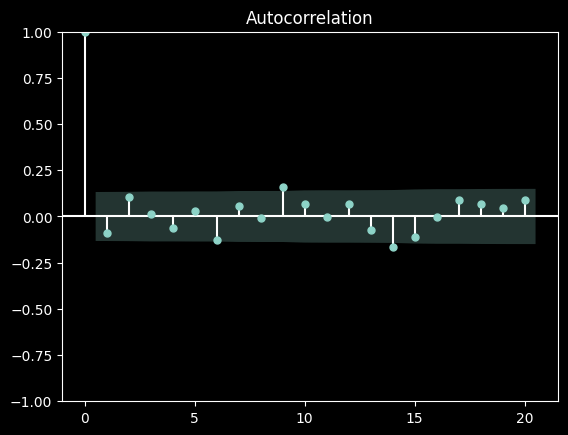

Estatística de Durbin-Watson: 2.1418


    lb_stat  lb_pvalue
5  5.423365   0.366422


In [16]:
plot_acf(data, lags=20)
plt.show()

# Teste Durbin-Watson
dw_stat = durbin_watson(data)
print(f"Estatística de Durbin-Watson: {dw_stat:.4f}\n\n")

# Teste Ljung-Box e BoxPierce
ljung_box_results = acorr_ljungbox(data, lags=[5], return_df=True)
print(ljung_box_results)

In [12]:
bds_test = bds(data)
print(bds_test)

(array(-0.24133796), array(0.8092932))


In [17]:
# Teste se a média dos retornos é 0
t_stat, p_value = stats.ttest_1samp(data, 0)
t_stat, p_value

(1.4111318349680873, 0.1596312627740057)